## Background

In this blog post I will train a deep learning model to classify two dependent variables in a tabular dataset. I'm not sure how this works under the hood and will use this as an opportunity to learn.

I will reference the code and logic from Jeremy Howard's notebook [Linear model and neural net from scratch](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch) where he builds a deep learning neural net from scratch.

## Plan of Attack

There are a few places in the existing code that I'll need to modify to fit a two-output use case:



### Prepping the Data

Currently, there are 12 different independent variables and 1 dependent variable. In my use case, I will have 11 independent variables and 2 dependent variables (`Age` and `Survived`).

The current dependent variables are turned into column vectors as follows:

```python
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]
```

I'm not sure if I'll have to do this for two dependent variables as well. It's something I'll look into and make sure matches the expected shape before I proceed.

### Initializing Coefficients

Currently, the `sizes` of each of the layers of the deep neural net are as follows:

```python
hiddens = [10,10]
sizes = [n_coeff] + hiddens + [1]
```

For a model with two outputs, the last layer will have size `2`:

```python
sizes = [n_coeff] + hiddens + [2]
```

### Calculating Predictions

When calculating predictions for one output, the final line returns `torch.sigmoid` of the result. In my case, that will work for predicting `Survived` since it's between 0 and 1, but `Age` is a continuous variable that can be greater than 0 so instead of `sigmoid` I'll use `F.relu` and see if that works.

### Calculating Loss

Here's the current loss function:

```python
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()
```

Given broadcasting, I think it should work as is, but will test it out and see.

### Calculating Metrics

Accuracy is calculated as follows:

```python
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
```

This will work for my first output (`Survived`) but I will need something else like Root Mean Squared Error for the second output `Age` which is continuous.

## Load and Clean the Data

I'll reuse the code in Jeremy's notebook which replaces NA values with the mode of each column, adds a `LogFare` column, and normalizes all columns.

In [2]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [3]:
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path("../input/titanic")
else:
  path = Path('titanic')
  if not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 15.4MB/s]

In [4]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [5]:
# load the training data
df = pd.read_csv(path/'train.csv')

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [7]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                      0.00
Pclass                        3.00
Name           Abbing, Mr. Anthony
Sex                           male
Age                          24.00
SibSp                         0.00
Parch                         0.00
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [8]:
df.fillna(modes, inplace=True)

In [9]:
df.isna().sum() # should be all zeros

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [10]:
df['LogFare'] = np.log(df['Fare']+1)

In [11]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [12]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

## Prepare Independent and Dependent Variables

In [13]:
# transposed so it has the shape 891, 2
t_dep = tensor(df.Survived, df.Age).T

In [14]:
t_dep.shape

torch.Size([891, 2])

In [15]:
t_dep[:5]

tensor([[ 0., 22.],
        [ 1., 38.],
        [ 1., 26.],
        [ 1., 35.],
        [ 0., 35.]])

In [16]:
indep_cols = ['SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep.shape

torch.Size([891, 11])

In [17]:
# normalize independent variables
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

In [18]:
t_indep[:2]

tensor([[0.1250, 0.0000, 0.3381, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000],
        [0.1250, 0.0000, 0.6859, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000]])

## Prepare Training and Validation Splits

In [19]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

In [20]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

## Define Training Functions

Next, I'll redefine the training functions in Jeremy's notebook to handle two outputs:

### Initializing Coefficients

In [21]:
def init_coeffs(n_coeff):
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [2]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

To make sure I understand what's going on in that function with this change, I'll run each line one at a time:

In [22]:
n_coeff = 11

In [23]:
hiddens = [10, 10]

In [24]:
sizes = [n_coeff] + hiddens + [2]

In [25]:
sizes

[11, 10, 10, 2]

In [26]:
n = len(sizes)
n

4

In [27]:
layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]

In [28]:
layers[0].shape

torch.Size([11, 10])

In [29]:
layers[1].shape

torch.Size([10, 10])

In [30]:
layers[2].shape

torch.Size([10, 2])

In [31]:
layers[2]

tensor([[-0.2763,  0.9819],
        [-0.2831,  1.3895],
        [-0.0237,  1.0026],
        [ 0.6002,  0.6650],
        [ 0.2466,  0.8107],
        [-0.0168, -0.5426],
        [ 0.0158,  1.1835],
        [ 0.1367,  0.7143],
        [ 0.0303,  1.1501],
        [ 0.9985,  0.7530]])

In [32]:
consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
consts

[tensor(-0.0256), tensor(-0.0409), tensor(0.0019)]

### Calculating Predictions

In [33]:
def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.stack([torch.sigmoid(res[:,0]), F.relu(res[:,1])]).T

I'll test out this function by initializing some random coefficients and using the independent variables to see what kind of outputs I get:

In [34]:
coeffs = init_coeffs(11)

In [35]:
# three layers and three constants
coeffs[0][0].shape, coeffs[0][1].shape, coeffs[0][2].shape, len(coeffs[1])

(torch.Size([11, 10]), torch.Size([10, 10]), torch.Size([10, 2]), 3)

In [36]:
layers,consts = coeffs

In [37]:
n = len(layers)
n

3

In [38]:
res = trn_indep

In [39]:
res.shape

torch.Size([713, 11])

In [40]:
# first layer
res = res@layers[0] + consts[0]
res = F.relu(res)

In [41]:
res.shape

torch.Size([713, 10])

In [42]:
# second layer
res = res@layers[1] + consts[1]
res = F.relu(res)

In [43]:
res.shape

torch.Size([713, 10])

In [44]:
# last layer
res = res@layers[2] + consts[2]
res.shape

torch.Size([713, 2])

In [45]:
# final treatment of predictions
torch.stack([torch.sigmoid(res[:,0]), F.relu(res[:,1])]).T.shape

torch.Size([713, 2])

### Calculating Loss

In [46]:
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

In [50]:
calc_preds(coeffs, trn_indep)[:2]

tensor([[0.7009, 1.4735],
        [0.7032, 1.3960]], grad_fn=<SliceBackward0>)

In [51]:
trn_dep[:2]

tensor([[ 1.0000,  1.0000],
        [ 0.0000, 40.5000]])

In [49]:
(calc_preds(coeffs, trn_indep)-trn_dep)[:5]

tensor([[ -0.2991,   0.4735],
        [  0.7032, -39.1040],
        [ -0.3204, -25.7099],
        [  0.6899, -28.6214],
        [  0.6613,  -1.9130]], grad_fn=<SliceBackward0>)

In [47]:
calc_loss(coeffs,trn_indep, trn_dep)

tensor(13.8010, grad_fn=<MeanBackward0>)

The loss function seems to work without modification so I'll keep it as is.

### Calculating Metrics

I am mixing a classification output (`Survived`) and a regression output (`Age`) so I'll have to spit back two different metrics.

In [64]:
def calc_metrics(coeffs):
  preds = calc_preds(coeffs, val_indep)
  acc = (val_dep[:,0].bool()==(preds[:,0]>0.5)).float().mean()
  rmse = ((preds[:,1]-val_dep[:,1])**2).mean().sqrt()
  return acc, rmse

I'll walk through the steps of calculating each metric manually. First, calculating accuracy for the `Survived` dependent variable:

In [53]:
preds = calc_preds(coeffs, val_indep)

In [57]:
(val_dep[:,0])[:5]

tensor([1., 0., 0., 0., 0.])

In [56]:
(preds[:,0]>0.5)[:5]

tensor([True, True, True, True, True])

In [58]:
(val_dep[:,0].bool()==(preds[:,0]>0.5))[:5]

tensor([ True, False, False, False, False])

In [62]:
(val_dep[:,0].bool()==(preds[:,0]>0.5)).float().mean()

tensor(0.4045)

Then, calculating RMSE for the `Age` dependent variable:

In [59]:
preds[:,1][:5]

tensor([1.4279, 1.3960, 1.3844, 1.7690, 1.7181], grad_fn=<SliceBackward0>)

In [60]:
val_dep[:,1][:5]

tensor([24., 24., 24., 18., 25.])

In [61]:
((preds[:,1]-val_dep[:,1])**2).mean().sqrt()

tensor(30.2869, grad_fn=<SqrtBackward0>)

Finally, testing the written function:

In [65]:
calc_metrics(coeffs)

(tensor(0.4045), tensor(30.2869, grad_fn=<SqrtBackward0>))

### Update Coefficients

In [67]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

### Training One Epoch

In [73]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad():
      update_coeffs(coeffs, lr)
      acc, rmse = calc_metrics(coeffs)
    print((acc.item(), rmse.item()), end="\n")

### Training the Model

In [84]:
def train_model(epochs=30, lr=0.01, n_coeff=11):
    coeffs = init_coeffs(n_coeff)
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

With everything (hopefully) in place, I'll try and train the model and see what happens:

In [86]:
coeffs = train_model()

(0.38764044642448425, 30.570125579833984)
(0.38764044642448425, 30.408233642578125)
(0.38764044642448425, 30.238630294799805)
(0.40449437499046326, 30.06170654296875)
(0.40449437499046326, 29.877859115600586)
(0.40449437499046326, 29.687469482421875)
(0.40449437499046326, 29.487010955810547)
(0.40449437499046326, 29.277685165405273)
(0.40449437499046326, 29.056915283203125)
(0.40449437499046326, 28.823810577392578)
(0.40449437499046326, 28.57526397705078)
(0.40449437499046326, 28.313222885131836)
(0.40449437499046326, 28.037466049194336)
(0.40449437499046326, 27.746822357177734)
(0.40449437499046326, 27.441844940185547)
(0.40449437499046326, 27.11766242980957)
(0.40449437499046326, 26.774660110473633)
(0.40449437499046326, 26.409164428710938)
(0.40449437499046326, 26.020383834838867)
(0.40449437499046326, 25.609088897705078)
(0.40449437499046326, 25.171112060546875)
(0.40449437499046326, 24.705785751342773)
(0.40449437499046326, 24.209741592407227)
(0.40449437499046326, 23.682376861572

The model is successfully training, so I take it that the code "works" in the sense that matrix multiplications and loss calculations are being performed. However, the accuracy for predicting `Survived` and the error for predicting `Age` are not great. Looking at some predictions:

In [89]:
val_dep[:10]

tensor([[ 1., 24.],
        [ 0., 24.],
        [ 0., 24.],
        [ 0., 18.],
        [ 0., 25.],
        [ 0., 34.],
        [ 1.,  4.],
        [ 1., 28.],
        [ 0.,  1.],
        [ 1., 24.]])

In [90]:
calc_preds(coeffs, val_indep)[:10]

tensor([[ 0.5220, 12.6086],
        [ 0.5365, 13.6072],
        [ 0.5167, 14.2770],
        [ 0.5119, 14.4791],
        [ 0.5162, 14.1781],
        [ 0.5163, 14.3243],
        [ 0.5276, 13.5216],
        [ 0.5296, 13.1540],
        [ 0.5437, 15.1101],
        [ 0.5275, 13.6733]], grad_fn=<SliceBackward0>)

## Running and Recording Trainings

I'll reuse code that I implemented in my previous blog post on [plotting losses and accuracy](http://vishalbakshi.com/blog/posts/2023-08-15-training-plots/2023_08_15_training_plots.html), modifying it to capture both accuracy and rmse from the training:

In [91]:
def one_epoch(coeffs, lr):
  trn_loss = calc_loss(coeffs, trn_indep, trn_dep)
  trn_loss.backward()
  with torch.no_grad():
    val_loss = calc_loss(coeffs, val_indep, val_dep)
    update_coeffs(coeffs, lr)
    acc, rmse = calc_metrics(coeffs)
  return trn_loss, val_loss, acc, rmse

In [92]:
def train_model(epochs, lr, n_coeff, is_seed=True):
  if is_seed: torch.manual_seed(442)
  tl, vl, a, r = [], [], [], []
  coeffs = init_coeffs(n_coeff)
  for i in range(epochs):
    trn_loss, val_loss, acc, rmse = one_epoch(coeffs, lr)
    tl.append(trn_loss.item())
    vl.append(val_loss.item())
    a.append(acc.item())
    r.append(rmse.item())
  return tl, vl, a, r

In [98]:
def train_multiple_models(runs=100, epochs=30, lr=4, n_coeff=11, is_seed=False):
  # initialize recorder object
  recorder = pd.DataFrame(columns=["run", "epoch", "trn_loss", "val_loss", "acc", "rmse"])
  for run in range(runs):
    # get lists of losses and accuracy
    tl, vl, a, rmse = train_model(epochs, lr, n_coeff, is_seed)
    # create list of run and epoch values
    r = [run] * epochs
    e = [i for i in range(epochs)]
    # append new data to recorder DataFrame
    row = pd.DataFrame(data={"run": r, "epoch": e, "trn_loss": tl, "val_loss": vl, "acc": a, "rmse": rmse})
    recorder = pd.concat([recorder, row])
  return recorder

In [99]:
recorder = train_multiple_models()

### Plotting Training Results

In [100]:
recorder.head()

,run,epoch,trn_loss,val_loss,acc,rmse
0,0,0,13.62,13.71,0.40,1187.97
1,0,1,594.61,594.02,0.60,31.69
2,0,2,14.51,14.62,0.60,31.69
3,0,3,14.50,14.61,0.60,31.69
4,0,4,14.50,14.61,0.60,31.69


In [101]:
recorder.tail()

,run,epoch,trn_loss,val_loss,acc,rmse
25,99,25,14.47,14.58,0.60,31.69
26,99,26,14.46,14.58,0.60,31.69
27,99,27,14.46,14.58,0.60,31.69
28,99,28,14.46,14.58,0.60,31.69
29,99,29,14.46,14.58,0.60,31.69


In [104]:
recorder['acc'].max()

0.5955055952072144

In [105]:
recorder['rmse'].min()

13.89392375946045

In [115]:
def plot_recorder(recorder):
  fig, axs = plt.subplots(2, 2)

  (recorder
   .pivot_table(values='trn_loss', index='epoch', columns='run')
   .plot(color='green', alpha=0.3, legend=False, title='Training Loss', ax=axs[0, 0]));

  (recorder
   .pivot_table(values='val_loss', index='epoch', columns='run')
   .plot(color='red', alpha=0.3, legend=False, title='Validation Loss', ax=axs[0,1]));

  (recorder
   .pivot_table(values='acc', index='epoch', columns='run')
   .plot(color='blue', alpha=0.3, legend=False, title='Accuracy', ax=axs[1,0]));

  (recorder
   .pivot_table(values='rmse', index='epoch', columns='run')
   .plot(color='orange', alpha=0.3, legend=False, title='RMSE', ax=axs[1,1]));

  for ax in axs.flat:
    ax.label_outer()

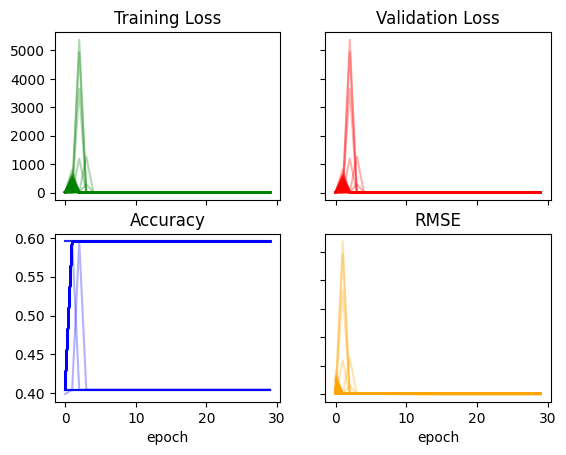

In [116]:
plot_recorder(recorder)

## Modifying the Model

I think the main takeaway from this exercise so far is that the model is unstable. The training runs don't look promising---there are sharp changes in loss and RMSE, and the accuracy plateaus quickly. I would hope to see relatively smooth curves in both losses and metrics across epochs.

Jeremy had [mentioned in the lesson video](https://youtu.be/_rXzeWq4C6w?t=4126) that he had to fiddle with some of the constants inside the neural network as well as the learning rate to get a stable training. So with that in mind, I'll give it a try and adjust those values and see if it makes training more stable.

The two things I'll fiddle with: the arbitrary constants in `init_coeffs` and the learning rate.

In [117]:
def init_coeffs(n_coeff):
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [2]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.5)/sizes[i+1]*6 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.5 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [118]:
recorder = train_multiple_models()

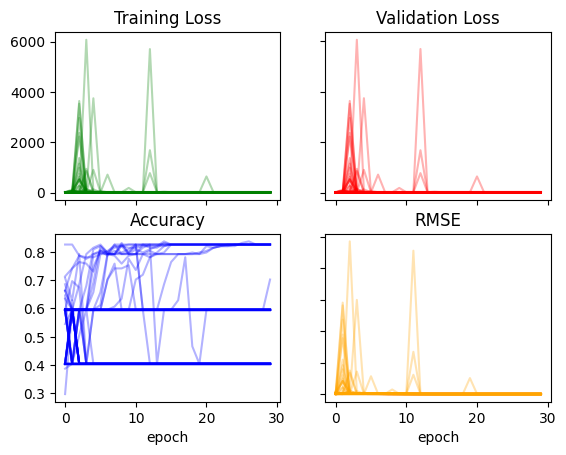

In [119]:
plot_recorder(recorder)

Increasing some of the constants somewhat improved the loss and RMSE and significantly improved the accuracy:

In [120]:
recorder['acc'].max(), recorder['rmse'].min()

(0.8370786309242249, 13.419356346130371)

In [121]:
recorder = train_multiple_models(lr=0.03)

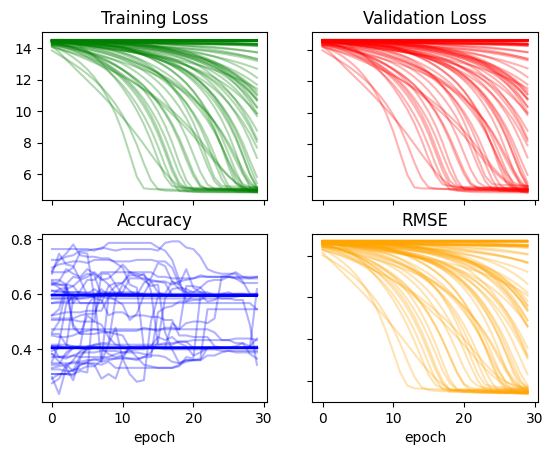

In [122]:
plot_recorder(recorder)

Increasing the learning rate significantly changed the way losses and RMSE change over time and seems to have made accuracy more chaotic. The minimum RMSE still remains at around 13:

In [123]:
recorder['acc'].max(), recorder['rmse'].min()

(0.7921348214149475, 13.494928359985352)

I'll continue to increase the constants in the model and the learning rate:

In [124]:
def init_coeffs(n_coeff):
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [2]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.75)/sizes[i+1]*8 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.75 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [125]:
recorder = train_multiple_models(lr=0.05)

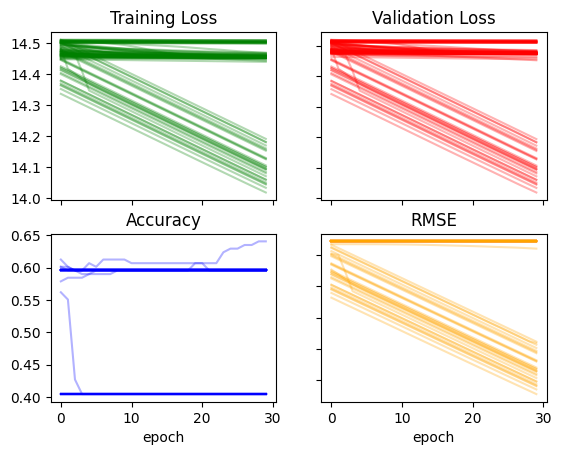

In [126]:
plot_recorder(recorder)

In [127]:
recorder['acc'].max(), recorder['rmse'].min()

(0.6404494643211365, 30.712871551513672)

I seem to have broken the model, I'll keep increasing the constants and learning rate one more time and see it if continues to break the training:

In [129]:
def init_coeffs(n_coeff):
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [2]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-1.0)/sizes[i+1]*10 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*1.00 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [130]:
recorder = train_multiple_models(lr=0.07)

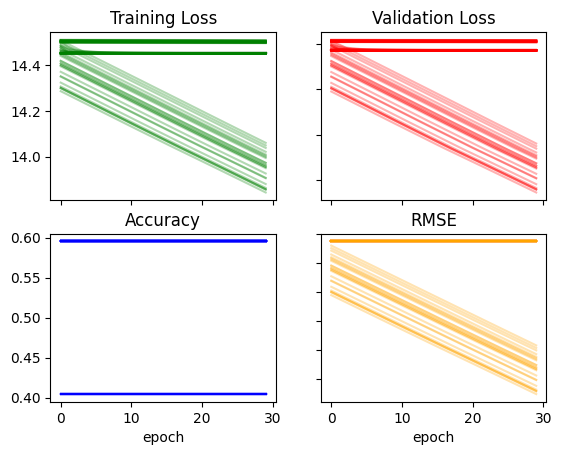

In [131]:
plot_recorder(recorder)

Okay continuing to increase them is not helping. I'll go in the opposite direction----decreasing the constants and learning rate:

In [132]:
def init_coeffs(n_coeff):
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [2]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.1)/sizes[i+1]*2 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.05 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [133]:
recorder = train_multiple_models(lr=0.005)

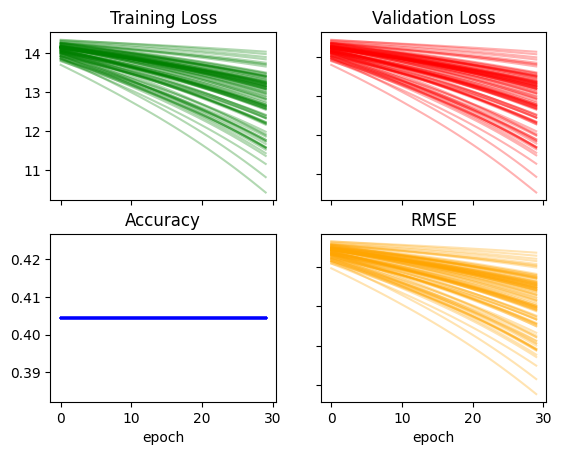

In [134]:
plot_recorder(recorder)

In [135]:
recorder['acc'].max(), recorder['rmse'].min()

(0.40449437499046326, 23.53632354736328)

The trainings look MUCH smoother in terms of loss and RMSE, however the accuracy does not improve at all in any of the 100 trainings and the minimum RMSE achieved is not as low as some of the previous configurations. I'll increase the learning rate and keep the constants as they are:

In [136]:
recorder = train_multiple_models(lr=0.01)

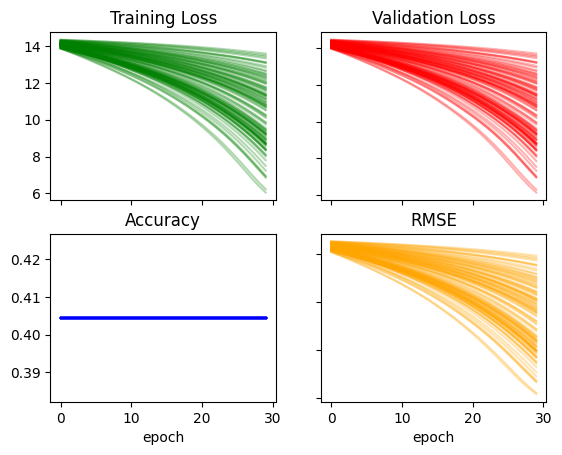

In [137]:
plot_recorder(recorder)

In [138]:
recorder['acc'].max(), recorder['rmse'].min()

(0.40449437499046326, 15.42644214630127)

Moving in the right direction for RMSE but still getting a bad accuracy. I'll increase the learning rate a bit more:

In [141]:
recorder = train_multiple_models(lr=0.03)

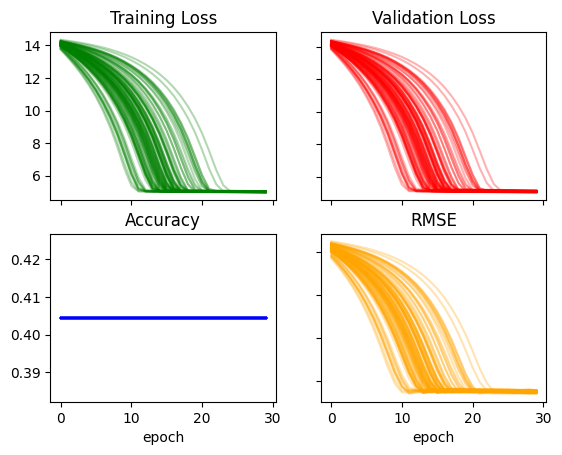

In [142]:
plot_recorder(recorder)

In [143]:
recorder['acc'].max(), recorder['rmse'].min()

(0.40449437499046326, 13.523417472839355)

Something about this new model favors `Age` and penalizes `Survived`. It's hard to know what is really going on. I'll continue to fiddle with the parameters:

In [144]:
def init_coeffs(n_coeff):
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [2]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.1)/sizes[i+1]*1 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [145]:
recorder = train_multiple_models(lr=0.01)

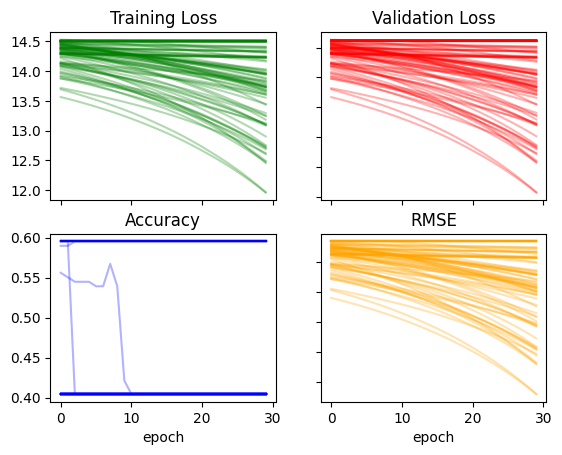

In [146]:
plot_recorder(recorder)

In [147]:
recorder['acc'].max(), recorder['rmse'].min()

(0.5955055952072144, 26.605520248413086)

I'll return to a previous configuration which yielded a pretty high accuracy (79%) and the lowest RMSE so far (13.5).

In [149]:
def init_coeffs(n_coeff):
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [2]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.5)/sizes[i+1]*6 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.5 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [171]:
recorder = train_multiple_models(lr=0.1)

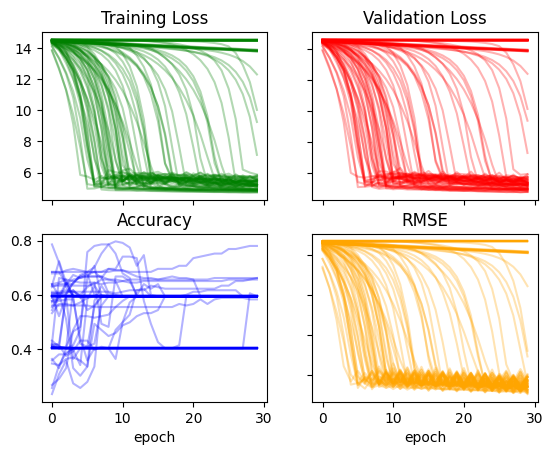

In [172]:
plot_recorder(recorder)

In [173]:
recorder['acc'].max(), recorder['rmse'].min()

(0.7977527976036072, 12.552786827087402)

I could go on and on with changing arbitrary constants and the learning rate, but I'll stop here as I'm getting a relatively stable training with a high accuracy and low RMSE. I'll take a look at `Age` predictions more closely here:

In [179]:
preds = calc_preds(coeffs, val_indep)

In [181]:
age_df = pd.DataFrame({'age_actual': val_dep[:,1].numpy(), 'age_pred': preds[:,1].detach().numpy()})

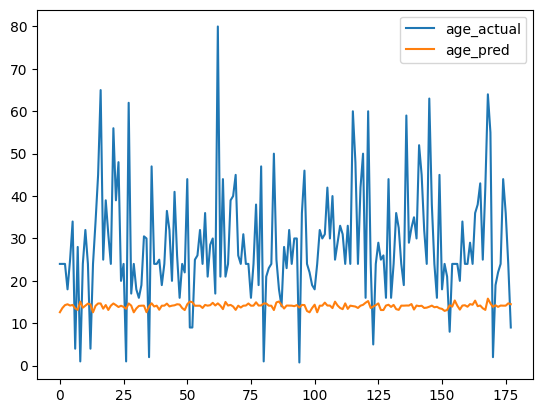

In [184]:
age_df.plot();

The model didn't really learn anything useful on how to calculate age. It essentially just found some average value and stuck with it for each passenger.

## Training a Regression Model for Age

Before I close out this blog post with my final thoughts, I want to see how well our model can predict `Age` as a single output. I'll rewrite the training functions to handle a single regression output value:

In [200]:
def init_coeffs(n_coeff):
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return 100 * torch.sigmoid(res) # assuming age is between 0 and 100

def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

def calc_rmse(coeffs):
  preds = calc_preds(coeffs, val_indep)
  rmse = ((preds-val_dep)**2).mean().sqrt()
  return rmse

def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad():
      update_coeffs(coeffs, lr)
      rmse = calc_rmse(coeffs)
    print(rmse.item(), end="\n")

def train_model(epochs=30, lr=0.01, n_coeff=11):
    coeffs = init_coeffs(n_coeff)
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

I'll re-prepare the data so that the appropriate variables are categorized as independent and dependent:

In [192]:
t_dep = tensor(df.Age)

In [193]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

In [195]:
val_indep.shape

torch.Size([178, 11])

In [197]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [198]:
val_dep.shape

torch.Size([178, 1])

In [201]:
coeffs = train_model()

40.933284759521484
20.56239128112793
17.421009063720703
15.360074996948242
14.128280639648438
13.583489418029785
13.374798774719238
13.349427223205566
13.402131080627441
13.475241661071777
13.540617942810059
13.617292404174805
13.704315185546875
13.765442848205566
13.83024787902832
13.8984956741333
13.92748737335205
13.957006454467773
13.987039566040039
14.017572402954102
14.045609474182129
14.074031829833984
14.102828979492188
14.131990432739258
14.161505699157715
14.191366195678711
13.757979393005371
13.822358131408691
13.89020824432373
13.91904354095459


In [202]:
preds = calc_preds(coeffs, val_indep)

In [214]:
age_df = pd.DataFrame({'age_actual': val_dep.squeeze(1).numpy(), 'age_pred': preds.squeeze(1).detach().numpy()})

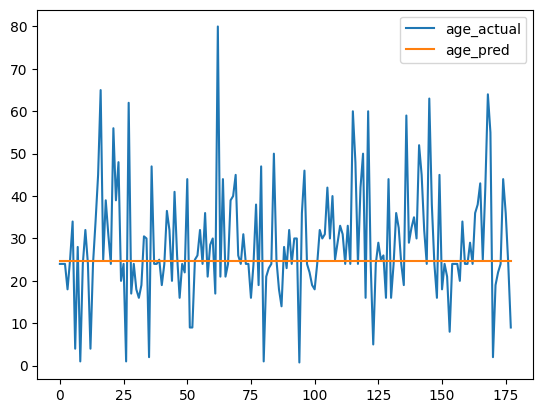

In [215]:
age_df.plot();

Again, the model does not seem to learn anything useful about age, it just finds the mean and uses it as the value for each prediction.

In [216]:
val_dep.mean()

tensor(28.7374)

In [220]:
preds.mode().values[0]

tensor(24.7849, grad_fn=<SelectBackward0>)

To see if I am getting this result just by chance, or if there is something consistent about this model's `Age` predictions, I'll train this model 100 times and plot the result age distribution:

In [230]:
def train_multiple_models(runs=100, epochs=30, lr=4, n_coeff=11, is_seed=False):
  recorder = pd.DataFrame()
  for run in range(runs):
    coeffs = train_model(epochs, lr, n_coeff)
    preds = calc_preds(coeffs, val_indep)
    recorder[run] = preds.squeeze(1).detach().numpy()
  return recorder

In [ ]:
recorder = train_multiple_models(lr=0.01)

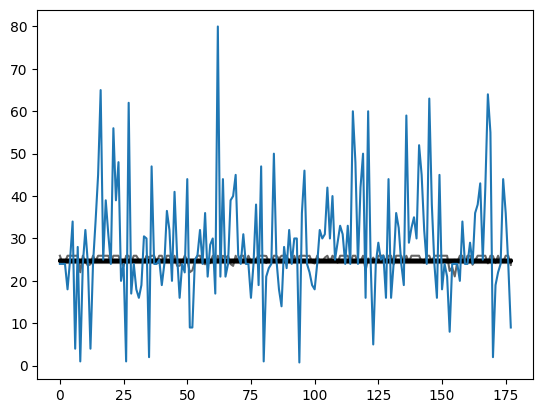

In [241]:
fig, ax = plt.subplots(1)

recorder.plot(legend=False, color='black', alpha=0.6, ax=ax);

ax.plot(val_dep.squeeze(1).numpy());

In many trainings (dark black lines between age values of 24 and 25) the model simply finds the mean. There are some training runs where the predicted age has slightly more variability, but it pales in comparison to the variability in actual age. I would imagine that changing the randomly instantiated coefficients' constants and learning rate would affect this result.

## Final Thoughts

Although my model was not successful in correctly prediction both the age of the passenger and whether they survived, I did find this exercise to be helpful. A few takeaways:

- Creating a model that predicts more than one variable will require modifying the model as well as the training and validation data structure.
- Changing the arbitrary coefficients inside the deep neural net and the learning rate significantly affects the training stability and classification accuracy.
- A simple deep learning model predicts the mean for continuous variables (based on what I've seen here).

I really enjoyed working through this example and feel more comfortable with building and modifying neural net architecture then when I started writing this blog post. I hope you enjoyed it too!